In [1]:
import networkx as nx
import numpy as np
from scipy.stats import uniform

# Helpful functions

In [2]:
def disagreement(G, opinions):
    disagreement = 0
    for i, nbrs in G.adj.items():
        for j, eattr in nbrs.items():
            disagreement += abs(eattr['weight']) * (opinions[i] - opinions[j])**2
    return disagreement

def polarization(G, opinions):
    average_opinion = np.sum(opinions) / len(G.nodes)
    mean_centered_opinion = opinions - average_opinion
    return mean_centered_opinion.T @ mean_centered_opinion

### Basic FJ model on $G_{n,p}$ for $p=\frac12$ where all weights are $w_{ij}$ uniform $[0,1]$ i.i.d., internal opinions are uniform $[0,1]$ i.i.d.

In [3]:
def run_fj_and_return_expressed_opinions():
    n = 300
    p = 1/2
    G = nx.erdos_renyi_graph(n, p)
    for edge in G.edges:
        G.edges[edge]['weight'] = uniform.rvs()
    
    internal_opinions = uniform.rvs(size=n)
    expressed_opinions = internal_opinions.copy()
    T = 1000
    for t in range(T):
        new_expressed_opinions = expressed_opinions.copy()
        for i, nbrs in G.adj.items():
            sum_neighboring_expressed_opinion = sum(expressed_opinions[j] * eattr['weight'] for j, eattr in nbrs.items())
            sum_neighboring_weight = sum(eattr['weight'] for j, eattr in nbrs.items())
            new_expressed_opinions[i] = (internal_opinions[i] + sum_neighboring_expressed_opinion) / (1 + sum_neighboring_weight)
        expressed_opinions = new_expressed_opinions.copy()
    return G, expressed_opinions

num_trials = 10
disagreements = []
polarizations = []
for trial in range(num_trials):
    G, opinions = run_fj_and_return_expressed_opinions()
    disagreements.append(disagreement(G, opinions))
    polarizations.append(polarization(G, opinions))

In [4]:
np.sum(disagreements) / num_trials, np.sum(polarizations) / num_trials

(np.float64(0.6532765533600633), np.float64(0.004455348958105064))

### Negative weight FJ model on $G_{n,p}$ for $p=\frac12$ where all weights are $w_{ij}$ uniform $[-1,1]$ i.i.d., internal opinions are uniform $[0,1]$ i.i.d. Using sigmoid function to normalize

In [5]:
from scipy.special import expit

In [6]:
def run_fj_and_return_expressed_opinions():
    n = 300
    p = 1/2
    G = nx.erdos_renyi_graph(n, p)
    for edge in G.edges:
        G.edges[edge]['weight'] = uniform.rvs(loc=-1, scale=2)
    
    internal_opinions = uniform.rvs(size=n)
    expressed_opinions = internal_opinions.copy()
    T = 1000
    for t in range(T):
        new_expressed_opinions = expressed_opinions.copy()
        for i, nbrs in G.adj.items():
            sum_neighboring_expressed_opinion = sum(expressed_opinions[j] * eattr['weight'] for j, eattr in nbrs.items())
            sum_neighboring_weight = sum(eattr['weight'] for j, eattr in nbrs.items())
            new_expressed_opinions[i] = expit(internal_opinions[i] + sum_neighboring_expressed_opinion)
        expressed_opinions = new_expressed_opinions.copy()
    return G, expressed_opinions

num_trials = 10
disagreements = []
polarizations = []
for trial in range(num_trials):
    G, opinions = run_fj_and_return_expressed_opinions()
    disagreements.append(disagreement(G, opinions))
    polarizations.append(polarization(G, opinions))

In [8]:
np.sum(disagreements) / num_trials, np.sum(polarizations) / num_trials

(np.float64(8809.911938472003), np.float64(58.37903571281214))

### Same setup, but with weight halving threshold model with uniform threshold $\theta_{ij} = \theta$

In [15]:
def run_fj_and_return_expressed_opinions(theta):
    n = 300
    p = 1/2
    G = nx.erdos_renyi_graph(n, p)
    for edge in G.edges:
        G.edges[edge]['weight'] = uniform.rvs()
    
    internal_opinions = uniform.rvs(size=n)
    expressed_opinions = internal_opinions.copy()

    def update_weights():
        for i, nbrs in G.adj.items():
            for j, eattr in nbrs.items():
                if abs(expressed_opinions[i] - expressed_opinions[j]) >= theta:
                    eattr['weight'] /= 2
    T = 1000
    for t in range(T):

        update_weights()

        new_expressed_opinions = expressed_opinions.copy()
        for i, nbrs in G.adj.items():
            sum_neighboring_expressed_opinion = sum(expressed_opinions[j] * eattr['weight'] for j, eattr in nbrs.items())
            sum_neighboring_weight = sum(eattr['weight'] for j, eattr in nbrs.items())
            new_expressed_opinions[i] = (internal_opinions[i] + sum_neighboring_expressed_opinion) / (1 + sum_neighboring_weight)
        expressed_opinions = new_expressed_opinions.copy()
    return G, expressed_opinions

def find_disagreement_and_polarization_given_theta(theta):
    num_trials = 3
    disagreements = []
    polarizations = []
    for trial in range(num_trials):
        G, opinions = run_fj_and_return_expressed_opinions(theta)
        disagreements.append(disagreement(G, opinions))
        polarizations.append(polarization(G, opinions))
    return np.sum(disagreements) / num_trials, np.sum(polarizations) / num_trials

average_disagreements = []
average_polarizations = []
thetas = np.linspace(0,1,num=10)
for theta in thetas:
    average_disagreement, average_polarization = find_disagreement_and_polarization_given_theta(theta)
    average_disagreements.append(average_disagreement)
    average_polarizations.append(average_polarization)

In [18]:
import matplotlib.pyplot as plt

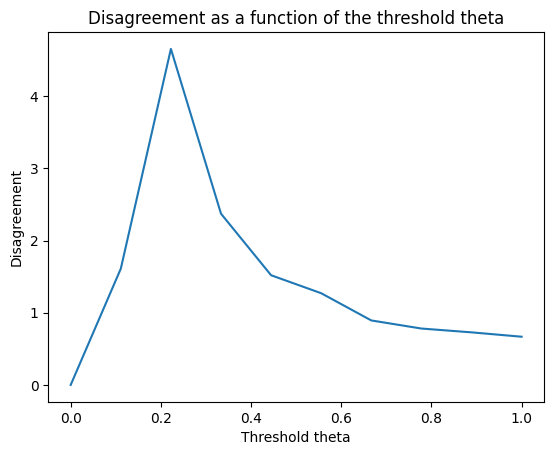

In [26]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Disagreement')
ax.set_title('Disagreement as a function of the threshold theta')
ax.plot(thetas, average_disagreements)
fig.savefig('threshold_model_halve_weight_disagreement.png')

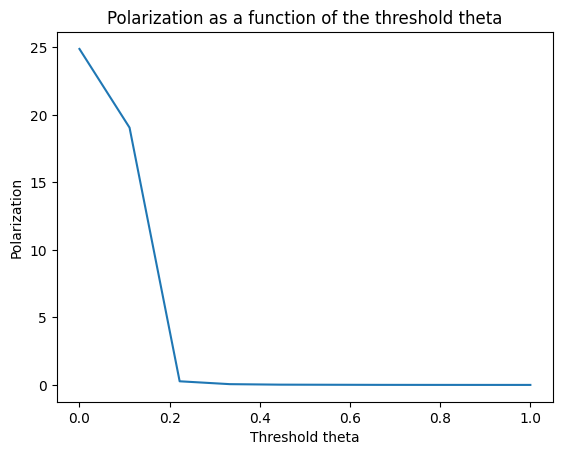

In [27]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Polarization')
ax.set_title('Polarization as a function of the threshold theta')
ax.plot(thetas, average_polarizations)
fig.savefig('threshold_model_halve_weight_polarization.png')

### Same thing, but weight increasing by $\delta = 1/10$

In [31]:
def run_fj_and_return_expressed_opinions(theta):
    n = 300
    p = 1/2
    G = nx.erdos_renyi_graph(n, p)
    for edge in G.edges:
        G.edges[edge]['weight'] = uniform.rvs()
    
    internal_opinions = uniform.rvs(size=n)
    expressed_opinions = internal_opinions.copy()

    delta = 1/10
    def update_weights():
        for i, nbrs in G.adj.items():
            for j, eattr in nbrs.items():
                if abs(expressed_opinions[i] - expressed_opinions[j]) >= theta:
                    eattr['weight'] = min(eattr['weight'] + delta, 1) 
    T = 1000
    for t in range(T):

        update_weights()

        new_expressed_opinions = expressed_opinions.copy()
        for i, nbrs in G.adj.items():
            sum_neighboring_expressed_opinion = sum(expressed_opinions[j] * eattr['weight'] for j, eattr in nbrs.items())
            sum_neighboring_weight = sum(eattr['weight'] for j, eattr in nbrs.items())
            new_expressed_opinions[i] = (internal_opinions[i] + sum_neighboring_expressed_opinion) / (1 + sum_neighboring_weight)
        expressed_opinions = new_expressed_opinions.copy()
    return G, expressed_opinions

def find_disagreement_and_polarization_given_theta(theta):
    num_trials = 3
    disagreements = []
    polarizations = []
    for trial in range(num_trials):
        G, opinions = run_fj_and_return_expressed_opinions(theta)
        disagreements.append(disagreement(G, opinions))
        polarizations.append(polarization(G, opinions))
    return np.sum(disagreements) / num_trials, np.sum(polarizations) / num_trials

average_disagreements = []
average_polarizations = []
thetas = np.linspace(0,1,num=10)
for theta in thetas:
    average_disagreement, average_polarization = find_disagreement_and_polarization_given_theta(theta)
    average_disagreements.append(average_disagreement)
    average_polarizations.append(average_polarization)

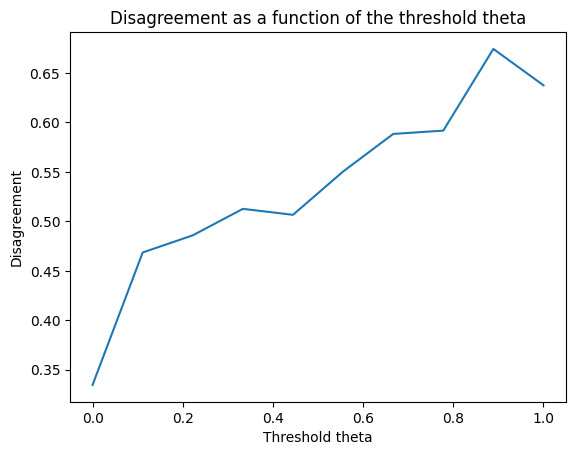

In [32]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Disagreement')
ax.set_title('Disagreement as a function of the threshold theta')
ax.plot(thetas, average_disagreements)
fig.savefig('threshold_model_increase_weight_disagreement.png')

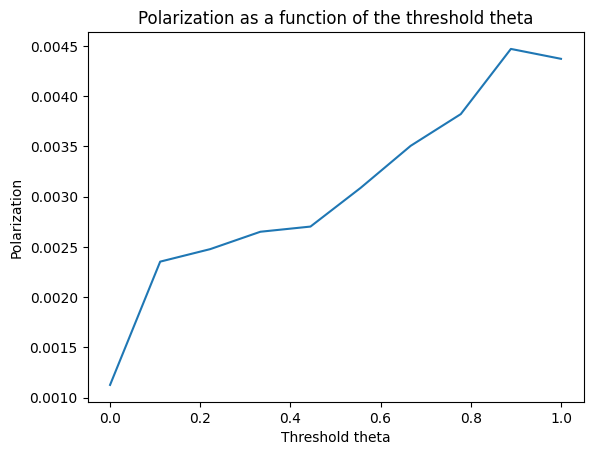

In [33]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Polarization')
ax.set_title('Polarization as a function of the threshold theta')
ax.plot(thetas, average_polarizations)
fig.savefig('threshold_model_increase_weight_polarization.png')

### Same thing but using the probabilistic model

In [34]:
from scipy.stats import bernoulli

In [ ]:
def run_fj_and_return_expressed_opinions(delta):
    n = 300
    p = 1/2
    G = nx.erdos_renyi_graph(n, p)
    for edge in G.edges:
        G.edges[edge]['weight'] = uniform.rvs()
    
    internal_opinions = uniform.rvs(size=n)
    expressed_opinions = internal_opinions.copy()

    def update_weights():
        for i, nbrs in G.adj.items():
            for j, eattr in nbrs.items():
                coin_flip = bernoulli.rvs(abs(expressed_opinions[i] - expressed_opinions[j]))
                if not coin_flip:
                    eattr['weight'] = min(eattr['weight'] + delta, 1) 
                else:
                    eattr['weight'] = max(eattr['weight'] - delta, 0)
                    
    T = 1000
    for t in range(T):

        update_weights()

        new_expressed_opinions = expressed_opinions.copy()
        for i, nbrs in G.adj.items():
            sum_neighboring_expressed_opinion = sum(expressed_opinions[j] * eattr['weight'] for j, eattr in nbrs.items())
            sum_neighboring_weight = sum(eattr['weight'] for j, eattr in nbrs.items())
            new_expressed_opinions[i] = (internal_opinions[i] + sum_neighboring_expressed_opinion) / (1 + sum_neighboring_weight)
        expressed_opinions = new_expressed_opinions.copy()
    return G, expressed_opinions

def find_disagreement_and_polarization_given_delta(delta):
    num_trials = 3
    disagreements = []
    polarizations = []
    for trial in range(num_trials):
        G, opinions = run_fj_and_return_expressed_opinions(delta)
        disagreements.append(disagreement(G, opinions))
        polarizations.append(polarization(G, opinions))
    return np.sum(disagreements) / num_trials, np.sum(polarizations) / num_trials

average_disagreements = []
average_polarizations = []
deltas = np.linspace(0,0.5,num=10)
for delta in deltas:
    average_disagreement, average_polarization = find_disagreement_and_polarization_given_delta(delta)
    average_disagreements.append(average_disagreement)
    average_polarizations.append(average_polarization)

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('Difference delta')
ax.set_ylabel('Disagreement')
ax.set_title('Disagreement as a function of the difference delta')
ax.plot(deltas, average_disagreements)
fig.savefig('probabilistic_model_disagreement.png')

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('Difference delta')
ax.set_ylabel('Polarization')
ax.set_title('Polarization as a function of the difference delta')
ax.plot(deltas, average_polarizations)
fig.savefig('probabilistic_model_polarization.png')